<!-- Assignment 4 - WS 2020 -->

# Adaptive Optimisation (15 points)

This notebook contains the fourth assignment for the exercises in Deep Learning and Neural Nets 1.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility function that should work without problems.
Please, do not alter this code or add extra import statements in your submission, unless it is explicitly requested!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the goal is to get familiar with some of the most common (adaptive) **optimisation algorithms**. Essentially, the most common optimisation algorithms are nothing more than variants of gradient descent. Although it is often claimed that stochastic gradient descent outperforms any adaptive learning method when carefully configured, it is often more convenient to use a method that requires less tuning.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from nnumpy import Module, Container#, LossFunction
from nnumpy.data import get_mnist_data
from nnumpy.utils import split_data, to_one_hot

%matplotlib inline

In [2]:
def accuracy(logits, labels):
    """
    Compute accuracy for classification network.
    
    Parameters
    ----------
    logits : ndarray
        The logit-predictions from the network.
    labels : ndarray
        The target labels for the task.
    
    Returns
    -------
    acc : float
        The fraction of correctly classified samples.
    """
    idx = np.argmax(logits, axis=1)
    return np.mean(labels[np.arange(len(idx)), idx])

In [3]:
class Optimiser:
    """ Base class for NNumpy optimisers. """

    def __init__(self, parameters, lr: float):
        """
        Create an optimiser instance.

        Parameters
        ----------
        parameters : iterable
            Iterable over the parameters that need to be updated.
        lr : float
            Learning rate or step size for updating the parameters.
        states : iterable
            Iterable over initial update states for each parameter.
        """
        self.parameters = list(parameters)
        if len(self.parameters) == 0:
            raise ValueError("no parameters to optimise")

        self.lr = float(lr)
        
        self._states = [self.init_state(par) for par in self.parameters]
    
    def init_state(self, par):
        """
        Create the initial optimiser state for a parameter.
        
        Parameters
        ----------
        par : Parameter
            The parameter to create the initial state for.
            
        Returns
        -------
        state : object
            The initial optimiser state for the given parameter.
        """
        return None

    def step(self):
        """
        Update all parameters under control of this optimiser
        by making one step in the direction computed by the algorithm
        for each of the parameters.
        """
        for par, state in zip(self.parameters, self._states):
            update = self.get_update(par, state)
            par -= self.lr * update
            del par.grad  # optional safeguard
    
    def get_update(self, par, state):
        """
        Compute the update for a single parameter.
        
        Parameters
        ----------
        par : Parameter
            The parameter (with `.grad` field) to compute the update for.
        state : object
            The state of the optimiser associated with the parameter.
        
        Returns
        -------
        
        """
        raise NotImplementedError("method must be implemented in subclass")

## Gradient Descent

As you should know by now, the *backpropagation* algorithm is little more than a combination of the chain rule and some form of gradient descent. Although this happens to work well in practice, it is good to be aware of possible issues when using first-order optimisation methods:

 1. Gradient descent can/will get stuck in *local minima*.
 2. The *gradient magnitude* tells you nothing about how far away minima are.
 3. When optimising the *empirical error*, gradient descent would require the gradient over the entire dataset.

Note that this last point is not necessarily an issue, but it is useful to keep in mind. Also, it implies that the gradients that can be computed on the entire dataset do not need to correspond to the gradients that would be required to minimise the generalisation error.

### Exercise 1: Stochasticity (2 Points)

Rather than using plain gradient descent algorithm, a stochastic variant is used to train neural networks. This variant is known as *Stochastic Gradient Descent*, or *SGD* for short. Although this naming scheme seems to suggest that stochasticity is part of the algorithm, it is actually introduced by how we use the data to compute gradients.

Instead of computing the gradients over the entire dataset in one go, the samples in the dataset are split up in more manageable pieces called *mini-batches*. This can speed up the computations significantly and avoids memory problems with very large datasets. Another benefit from mini-batches is that they introduce variation, or *stochasticity*, in the gradient computations. After all, the gradient for each mini-batch will be different to the gradient for other mini-batches or for all samples. This stochasticity can be useful to escape local minima in the optimisation process. To amplify this stochasticity, it is also common to shuffle the samples in the dataset so that mini-batches consist of different samples.

> Complete the `Dataloader` class below to process the data in mini-batches of pre-specified size. Also make sure to shuffle the data to get more stochasticity.

##### Some Notes on python generators

In python, a [generator](https://wiki.python.org/moin/Generators) is a function with some state that can return multiple values. You probably have already used generators without realising it. Probably, the most famous generator is `range`, which could be defined as follows:
```python
def _range(start, stop, step=1):
    i = start
    while i < stop:
        yield i
        i += step
```

Notice the `yield` keyword. This has a similar effect as `return` in that it provides a value to the outer scope of the function. However, it does not cause the function to be exited. Instead, the current state in the function is stored until the next value is requested. To get the return values of a generator, there are essentially two options:
 1. Using the `next` function. This will simply run the function until the next `yield` statement and give back the yielded value.
 2. By iterating over the generator in any way. This will consequently call `next` on the generator until the function exits.
 
For more information, please refer to the internet.

In [16]:
class Dataloader:
    
    def __init__(self, x, y, batch_size=None, shuffle=False, seed=None):
        """
        Parameters
        ----------
        x : (N, ...) ndarray
            the `N` input samples in the dataset
        y : (N, ...) ndarray
            the `N` output samples in the dataset
        batch_size : int, optional
            number of samples to include in a single mini-batch.
        shuffle : bool, optional
            whether or not the data should be shuffled.
        seed : int, optional
            seed for the pseudo random number generator used for shuffling.
        """
        self.x = x
        self.y = y
        self.batch_size = len(x) if batch_size is None else int(batch_size)
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)
    
    def __iter__(self):
        """
        Iterates over the samples of the data.
        
        Yields
        ------
        x : ndarray
            input features for the batch
        y : ndarray
            target values for the batch
            
        Notes
        -----
        Each batch should contain the specified number of samples,
        except for the last batch if the batch_size does 
        not divide the number of samples in the data.
        """
        x, y = np.copy(self.x), np.copy(self.y)
        if self.shuffle:
            state = self.rng.bit_generator.state
            self.rng.shuffle(self.x)  # np.random.shuffle(self.x)
            self.rng.bit_generator.state = state 
            self.rng.shuffle(self.y)  # np.random.shuffle(self.y)
        # for cnt in range(self.__len__()):
        #     batch_start_index = cnt*self.batch_size
        #     batch_stop_index = (cnt+1)*self.batch_size
        #     if batch_stop_index < len(self.x):
        #         yield self.x[batch_start_index:batch_stop_index], self.y[batch_start_index:batch_stop_index]
        #     else:
        #         yield self.x[batch_start_index:], self.y[batch_start_index:]
        
        # my solution
        for idx in range(0, len(self.x), self.batch_size):
            yield self.x[idx:idx+self.batch_size], self.y[idx:idx+self.batch_size]
#             if idx < (len(self.x) - self.batch_size):
#                 yield self.x[idx:idx+self.batch_size], self.y[idx:idx+self.batch_size]
#             else:
#                 yield self.x[idx:], self.y[idx:]

        return
        raise NotImplementedError("TODO: implement the dataloader.__iter__ function!")
            
    def __len__(self):
        return 1 + (len(self.x) - 1) // self.batch_size

In [17]:
# sanity check
data_loader = Dataloader(np.arange(7), np.arange(7), batch_size=3, shuffle=True)
print(len(data_loader))
for x, y in data_loader:
    print(x.shape, y.shape)
print(x, y)

3
(3,) (3,)
(3,) (3,)
(1,) (1,)
[6] [6]


### Exercise 2: Gradient Descent with Momentum (2 Points)

Another way to keep gradient descent from getting stuck in local minima is to use momentum. Momentum accumulates the gradient directions over different batches and accelerates/decelarates the descent when all gradients point in the same/different direction(s). This also means that the update does not directly use the magnitude of the gradient, but instead focuses on the direction. 

> Implement the `get_update` method for the gradient descent optimiser with momentum.

**Hint:** you can use in-place operations to change numpy arrays in the state

In [8]:
class GradientDescent(Optimiser):
    """ NNumpy implementation of gradient descent. """

    def __init__(self, parameters, lr: float, momentum: float = 0.):
        """
        Parameters
        ----------
        momentum : float
            Momentum term for the gradient descent.
        """
        super().__init__(parameters, lr)
        self.mu = momentum

    def init_state(self, par):
        state = np.zeros(par.shape)  # (1 - self.mu) * par.grad
        return state
        raise NotImplementedError("TODO: implement the GradientDescent.init_state function!")

    def get_update(self, par, state):
        self._state *= self.mu
        self._state += (1 - self.mu) * par.grad
        return self._state
        raise NotImplementedError("TODO: implement the GradientDescent.get_update function!")


### Exercise 3: The Adam Optimiser (4 Points)

Momentum already provides a way to reduce the importance of the gradient magnitude. With adaptive learning rate methods, an attempt is made to ignore most of the magnitude information and the size of the update is mainly controlled by controlling the learning rate. One of the most popular first order adaptive methods in practice, is the Adam optimiser.

> Implement the `get_update` method for the Adam optimisation algorithm.

**Hint:** you can use in-place operations to change numpy arrays in the state

In [26]:
class Adam(Optimiser):
    """ NNumpy implementation of the Adam algorithm. """

    def __init__(self, parameters, lr: float = 1e-3, betas: tuple = (.9, .999),
                 epsilon: float = 1e-7, bias_correction=True):
        """
        Parameters
        ----------
        betas : tuple of 2 floats, optional
            Decay factors for the exponential averaging of mean, resp. variance.
        epsilon : float, optional
            Small number that is added to denominator for numerical stability.
        bias_correction : bool, optional
            Whether or not mean and bias estimates should be bias-corrected.
        """
        super().__init__(parameters, lr)

        beta1, beta2 = betas
        self.beta1 = float(beta1)
        self.beta2 = float(beta2)
        self.eps = float(epsilon)
        self.bias_correction = bias_correction

    def init_state(self, par):
        state = (np.zeros(par.shape), np.zeros(par.shape), np.zeros(1))  # (0, (1 - self.beta1) * par.grad, (1 - self.beta2) * (par.grad ** 2))
        return state
        raise NotImplementedError("TODO: implement the Adam.init_state function!")

    def get_update(self, par, state):
        # self._state[0] += 1
        # time = self._state[0]
        #
        # self._state[1] *= self.beta1
        # self._state[1] += (1 - self.beta1) * par.grad
        #
        # self._state[2] *= self.beta2
        # self._state[2] += (1 - self.beta2) * (par.grad ** 2)
        #
        # if self.bias_correction:
        #     self._state[1] /= (1 - self.beta1 ** time)
        #     self._state[2] /= (1 - self.beta2 ** time)
        #
        # return self._state[1] / (np.sqrt(self._state[2]) + self.eps)
        mt, vt, step_cnt = state
        mt *= self.beta1
        mt += ((1 - self.beta1) * par.grad)

        vt *= self.beta2
        vt += ((1 - self.beta2) * (par.grad ** 2))
        
        step_cnt += 1
        
        # bias correction not in-place!!! 
        if self.bias_correction:
           mt = mt/(1 - self.beta1 ** step_cnt)
           vt = vt/(1 - self.beta2 ** step_cnt)

        return mt / (np.sqrt(vt) + self.eps)
        raise NotImplementedError("TODO: implement the Adam.get_update function!")


### Exercise 4: Evaluation and Update (3 Points)

When using the optimisers to fit a neural network to a given set of data, we can effectively minimise the empirical error. However, we are actually interested in minimising the risk. Therefore, it is also useful to evaluate the network regularly on unseen data.

 > Implement the `evaluate`, and `update` functions so that they perform the training and evaluation computations, respectively, for one iteration (aka *epoch*) over the entire dataset. Make sure to return the loss values to get loss curves at the end of this assignment.
 
**Hint:** you can use the `step` function of the optimiser to update the parameters.

In [27]:
def evaluate(network, metric, data_loader):
    """
    Evaluate a network by computing a metric for specific data.

    Parameters
    ----------
    network : Module
        A module that implements the network.
    metric : callable
        A function that takes logits and labels
        and returns a scalar numpy array.
    data_loader : Dataloader
        The data loader that provides the batches.

    Returns
    -------
    values : ndarray
        The computed metric values for each batch in the data loader.
    """
    network.eval()
    loss_list = []
    for data_batch, labels_batch in data_loader:
        output_batch = network(data_batch)
        loss_value = metric(output_batch, labels_batch)
        loss_list.append(loss_value.item())

    values = np.array(loss_list)
    return values
    raise NotImplementedError("TODO: implement the evaluate function!")


def update(network, loss, data_loader, optimiser):
    """
    Update a network by optimising the loss for the given data.

    Parameters
    ----------
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    data_loader : Dataloader
        The data loader that provides the batches.
    optimiser : Optimiser
        Optimisation algorithm to use for the update.

    Returns
    -------
    errors : ndarray
        The computed loss for each batch in the data loader.
    """
    network.train()
    loss.train()
    loss_list = []
    for data_batch, labels_batch in data_loader:
        output_batch = network(data_batch)
        loss_value = loss(output_batch, labels_batch)
        loss_list.append(loss_value)
        
        # compute the gradient for each mini-batch data
        network.zero_grad()
        delta, dy = loss.backward(1)
        dx = network.backward(delta)
        optimiser.step()

    errors = np.array(loss_list)
    return errors
    raise NotImplementedError("TODO: implement the update function!")


In [28]:
def train(train_data, valid_data, network, loss, optimiser, 
          epochs=1, batch_size=None, shuffle=True):
    """
    Train a neural network with gradient descent.
    
    Parameters
    ----------
    train_data : tuple of ndarrays
        Training data as tuple of input features and target values.
    valid_data : tuple of ndarrays
        Validation data as tuple of input features and target values.
    network : Module
        A module that implements the network.
    loss : Module
        Loss function module.
    optimiser : Optimiser
        Optimisation algorithm.
    epochs : int, optional
        Number of times to iterate the dataset.
    batch_size : int or None, optional
        Number of samples to use simultaneously.
        If None, all samples are fed to the network.
    shuffle : bool, optional
        Flag to enable or disable shuffling of the training data.
        
    Returns
    -------
    train_errors : (epochs + 1, n_batches) ndarray
        Training error for each epoch and each batch.
    valid_errors : (epochs + 1, 1) ndarray
        Validation error for each epoch.
    """
    train_loader = Dataloader(*train_data, batch_size=batch_size, shuffle=shuffle)
    valid_loader = Dataloader(*valid_data, batch_size=None)
    
    # log performance before training (for reference)
    train_errors = [evaluate(network, loss.eval(), train_loader)]
    valid_errors = [evaluate(network, loss.eval(), valid_loader)]
    # train for given number of epochs
    for _ in range(epochs):
        train_errors.append(update(network, loss, train_loader, optimiser))
        valid_errors.append(evaluate(network, loss.eval(), valid_loader))
        
    return np.stack(train_errors), np.stack(valid_errors)

### Exercise 5: Training a Neural Network (4 Points)

At this point, we have all ingredients to train fully connected and/or convolutional networks. Time to put your framework to the test and train a neural network to recognise hand-written digits.

> Use one of the optimisers from above to train a convolutional neural network on the MNIST dataset. You can use the `get_mnist_data` to download/process the data for this exercise. You will also need to create a neural network, for which you can make use of all modules from previous assignments. You are also allowed to create new modules and try out new things of course (make sure to include any new code in the notebook!). Achieve a model with 80% accuracy to collect all points. For reference: the sample solution (using the LeNet architecture illustrated below) takes &approx;15&nbsp;min to train for 10&nbsp;epochs.

**Hint:** Start with small models on a subset of the data. This will save you valuable time when trying out different settings!

<figure>
    <figcaption style="width: 100%; text-align: center;">LeNet-5 architecture</figcaption>
    <img src="https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png" />
</figure>

In [34]:
# import the modules you have written in the previous assignment
# or alternatively, the code for these modules, here
# e.g. from nnumpy import Sequential, Linear, Conv2D, Tanh, LogitCrossEntropy
from nnumpy.nn_modules import Sequential, Linear, Conv2D, Tanh, LogitCrossEntropy, AvgPool2d

In [36]:
class ScaledTanh(Tanh):
    def __init(self, bound = 1.7159, slope = 2./3.):
        super.__init__()
        self.bound = bound
        self.slope = slope
        
    def compute_outputs(self, x):
        a, cache = super().compute_outputs(self.slope * x)
        return self.bound * a, cache
    
    def compute_grads(self, grads, cache):
        return self.slope * super().compute_grads(self.bound * grads, cache)
        

In [37]:
def process_data(x_train, y_train):
    x_train = x_train.reshape(-1, 1, 28, 28)
    x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)))
    y_train = to_one_hot(y_train)
    return x_train, y_train

x_train, y_train = get_mnist_data()
x_train, y_train = process_data(x_train, y_train)
print(x_train.shape, y_train.shape)

(60000, 1, 32, 32) (60000, 10)


In [38]:
# you can create additional modules below
class Flatten(Module):
    """ NNumpy module to convert multi-dimensional outputs to a single vector. """
    
    def compute_outputs(self, x):
        return x.reshape(len(x), -1), x.shape
    
    def compute_grads(self, grads, shape):
        return grads.reshape(shape)

In [43]:
# raise NotImplementedError("TODO: create a convolutional network and train it!")
n_classes = 10
conv1 = Conv2D(in_channels=1, out_channels=6, kernel_size=(5, 5))
conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=(5, 5))
conv3 = Conv2D(in_channels=16, out_channels=120, kernel_size=(5, 5))
linear1 = Linear(in_features=120, out_features=84)
linear2 = Linear(in_features=84, out_features=n_classes)
tanh = Tanh()  # ScaledTanh()  #
avgpool = AvgPool2d(kernel_size=(2, 2))
flatten = Flatten()
cnn = Sequential(
    conv1,
    tanh,
    avgpool,
    conv2,
    tanh,
    avgpool,
    conv3,
    tanh,
    flatten,
    linear1,
    tanh,
    linear2,
)

loss = LogitCrossEntropy()
optimiser = Adam(cnn.parameters(), lr = 1e-2)

train_data, valid_data = split_data(x_train, y_train, 0.75)  # ((x_train[:10000], y_train[:10000]), (x_train[-1000:], y_train[-1000:]))
train_err, valid_err = train(train_data, valid_data, cnn, loss, optimiser, epochs=5, batch_size=64)
# train_data, valid_data = ...
# train_err, valid_err = train(...)

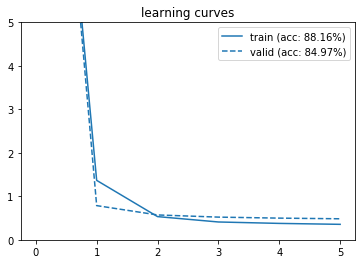

In [44]:
# plot learning curves
plt.title("learning curves")
train_acc, = evaluate(cnn, accuracy, Dataloader(*train_data))
loss_curve, = plt.plot(np.mean(train_err, axis=1), 
                       label=f'train (acc: {100 * train_acc:2.2f}%)')
valid_acc, = evaluate(cnn, accuracy, Dataloader(*valid_data))
plt.plot(valid_err, linestyle='--', color=loss_curve.get_color(), 
         label=f'valid (acc: {100 * valid_acc:2.2f}%)')
plt.ylim(0, 5)  # you can change the upper limit if you want
plt.legend();